<a href="https://colab.research.google.com/github/vinodnbhat/AIML_CEP_2021/blob/main/Resnet_Cifar10_TA_session_Nov04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imort the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

##CIFAR-10 dataset:

The dataset consists of 60,000 32x32 color images in 10 different classes with each class having 6,000 images. There are 50,000 train images and 10,000 test images. The classes are:
* Airplanes
* Cars
* Birds
* Cats
* Deer
* Dogs
* Frogs
* Horses
* Ships
* Trucks



In [ ]:
ROOT = '.data'


#downloading cifar10 dataset from torchvision.datasets
train_data = datasets.CIFAR10(root = ROOT, 
                             train = True, 
                             download = True)

mean = train_data.data.mean() / 255
std = train_data.data.std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')


Files already downloaded and verified
Calculated mean: 0.4733630004850899
Calculated std: 0.2515689250632208


In [ ]:
print(train_data.data.shape)

(50000, 32, 32, 3)


In [ ]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [ ]:
train_set = datasets.CIFAR10(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_set = datasets.CIFAR10(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_set.data.shape)

(50000, 32, 32, 3)


In [ ]:
print(test_set.data.shape)

(10000, 32, 32, 3)


In [ ]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of testing examples: {len(test_set)}')

Number of training examples: 50000
Number of testing examples: 10000


In [ ]:
batch_size = 64

#iterators for shuffling and loading data in batches 
train_loader = data.DataLoader(train_set, 
                                 shuffle = True, 
                                 batch_size = batch_size)

test_loader = data.DataLoader(test_set, 
                                batch_size = batch_size)

In [ ]:
# Checking the batch dimensions 
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [ ]:
### Model settings###

# Hyperparameters
learning_rate = 0.01

# Architecture
num_classes = 10


#Resnet 

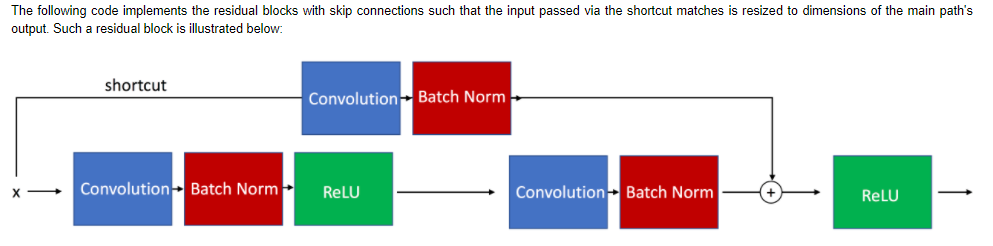

In [ ]:
class ResNet(torch.nn.Module):

    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        
        # 1st residual block#
        #########################################################################
        # 32x32x3 => 16x16x32
        self.conv1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv1_bn = torch.nn.BatchNorm2d(32)
                                    
        # 16x16x32 => 16x16x64
        self.conv2 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv2_bn = torch.nn.BatchNorm2d(64)

        
        
        # 32x32x3 => 16x16x64
        self.conv_shortcut1 = torch.nn.Conv2d(in_channels=3,
                                               out_channels=64,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut1_bn = torch.nn.BatchNorm2d(64)
        ############################################################################
    
        #2nd residual block#
        ###########################################################################
        # 16x16x64 => 8x8x128
        self.conv3 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=128,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv3_bn = torch.nn.BatchNorm2d(128)
                                    
        # 8x8x128 => 8x8x256
        self.conv4 = torch.nn.Conv2d(in_channels=128,
                                      out_channels=256,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv4_bn = torch.nn.BatchNorm2d(256)
        
        # 16x16x64 => 8x8x256 
        self.conv_shortcut2 = torch.nn.Conv2d(in_channels=64,
                                               out_channels=256,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut2_bn = torch.nn.BatchNorm2d(256)
        ############################################################################


        # Fully connected
        #########################        
        self.linear_1 = torch.nn.Linear(8*8*256, num_classes)

    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        shortcut = x
        
        out = self.conv1(x) # 32x32x3 => 16x16x32
        out = self.conv1_bn(out)
        out = F.relu(out)

        out = self.conv2(out) # 16x16x32 => 16x16x64
        out = self.conv2_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut1(shortcut)
        shortcut = self.conv_shortcut1_bn(shortcut)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        shortcut = out
        
        out = self.conv3(out) # 16x16x64 => 8x8x128
        out = self.conv3_bn(out)
        out = F.relu(out)

        out = self.conv4(out) # 8x8x128 => 8x8x256
        out = self.conv4_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut2(shortcut)
        shortcut = self.conv_shortcut2_bn(shortcut)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### Fully connected
        #########################   
        logits = self.linear_1(out.view(-1, 8*8*256))
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
# Initialize the model
model = ResNet()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 292,234 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
lossfn = nn.CrossEntropyLoss()

In [ ]:
if torch.cuda.is_available():
  print('cuda available! using cuda..')
else:
  print('cuda not available! using cpu..')    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda available! using cuda..


In [ ]:
model = model.to(device)
lossfn = lossfn.to(device)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Compute the Accuracy
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred_logits, y_pred_probas = model(x)
        
        loss = lossfn(y_pred_logits, y)
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [ ]:
save_model = False
patience_early_stopping = 3  #training will stop if model performance does not improve for these many consecutive epochs
cnt = 0 #counter for checking patience level
EPOCHS = 100
prev_test_acc = 0 #initializing prev test accuracy for early stopping condition
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) #learning rate scheduler, update learning rate by 
#factor of 0.2 if test accuracy does not improve for patience+1 consecutive epochs
for epoch in range(EPOCHS):
    print("current learning rate", optimizer.state_dict()['param_groups'][0]['lr'])
    start_time = time.perf_counter()
    
    train_loss = train(model, train_loader, optimizer, lossfn, device)
    train_acc = compute_accuracy(model, train_loader)

    if save_model:
        torch.save(model.state_dict(), 'resnet_model.pt')
    
    if epoch%1==0: #for every epoch we shall compute the test accuracy
        test_acc = compute_accuracy(model, test_loader)
        
        if test_acc > prev_test_acc: #check if test accuracy for current epoch has improved compared to previous epoch
          cnt = 0                    #f accuracy improves reset counter to 0

        else:                        #otherwise increment current counter
          cnt += 1

        prev_test_acc = test_acc

    
    scheduler.step(test_acc) #updates learning rate
    
        
    end_time = time.perf_counter()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    if epoch%1==0: #for every epoch we shall print the test loss and test accuracy 
        print(f'\t test Acc: {test_acc:.2f}% \n')

    if cnt == patience_early_stopping:
      print(f"early stopping as test accuracy did not improve for {patience_early_stopping} consecutive epochs")
      break

current learning rate 0.01
Epoch:  1 | Epoch Time: 0m 43s
	Train Loss: 1.980 | Train Acc: 53.44%
	 test Acc: 50.78% 

current learning rate 0.01
Epoch:  2 | Epoch Time: 0m 43s
	Train Loss: 1.278 | Train Acc: 59.85%
	 test Acc: 56.50% 

current learning rate 0.01
Epoch:  3 | Epoch Time: 0m 43s
	Train Loss: 1.139 | Train Acc: 64.12%
	 test Acc: 58.84% 

current learning rate 0.01
Epoch:  4 | Epoch Time: 0m 43s
	Train Loss: 1.045 | Train Acc: 67.47%
	 test Acc: 60.88% 

current learning rate 0.01
Epoch:  5 | Epoch Time: 0m 43s
	Train Loss: 0.975 | Train Acc: 70.14%
	 test Acc: 61.93% 

current learning rate 0.01
Epoch:  6 | Epoch Time: 0m 43s
	Train Loss: 0.924 | Train Acc: 71.28%
	 test Acc: 61.75% 

current learning rate 0.01
Epoch:  7 | Epoch Time: 0m 43s
	Train Loss: 0.871 | Train Acc: 72.11%
	 test Acc: 61.57% 

current learning rate 0.002
Epoch:  8 | Epoch Time: 0m 43s
	Train Loss: 0.625 | Train Acc: 82.09%
	 test Acc: 64.95% 

current learning rate 0.002
Epoch:  9 | Epoch Time: 0m 